# Week 1 - Retreiving and Preparing Text for Machines

This week, we begin by "begging, borrowing and stealing" text from several
contexts of human communication (e.g., PDFs, HTML, Word) and preparing it for
machines to "read" and analyze. This notebook outlines scraping text from the
web, from images, PDF and Word documents. Then we detail "spidering" or walking
through hyperlinks to build samples of online content, and using APIs,
Application Programming Interfaces, provided by webservices to access their
content. Along the way, we will use regular expressions, outlined in the
reading, to remove unwanted formatting and ornamentation. Finally, we discuss
various text encodings, filtering and data structures in which text can be
placed for analysis.

For this notebook we will be using the following packages:

In [1]:
#All these packages need to be installed from pip
import requests #for http requests
import bs4 #called `beautifulsoup4`, an html parser
import pandas #gives us DataFrames
import docx #reading MS doc files, install as `python-docx`
import PIL.Image #called `pillow`, an image processing library
import pytesseract #an interface to Tesseract, you will need Tesseract
import praw #For getting the reddit data
import nltk #The Natural Language Toolkit, for dealing with text
import numpy as np #Gives us arrays and some other nice math tools
import matplotlib.pyplot as plt #Makes plots
import seaborn #Makes the plots look nice

#install as `scikit-learn`, provides a large collection of Machine learning tools
#Each should be imported seperatly
import sklearn
import sklearn.feature_extraction
import sklearn.linear_model
import sklearn.ensemble
import sklearn.tree
import sklearn.linear_model
import sklearn.metrics

#Stuff for pdfs
#Install as `pdfminer2`
import pdfminer.pdfinterp
import pdfminer.converter
import pdfminer.layout
import pdfminer.pdfpage

#These come with Python
import re #for regexs
import urllib.parse #For joining urls
import io #for making http requests look like files
import json #For Tumblr API responses
import os.path #For checking if files exist
import os #For making directories
import json #For loading the reddit account data

We will also be working on the following files/urls

In [2]:
wikipedia_base_url = 'https://en.wikipedia.org'
wikipedia_intelligence_amplification = 'https://en.wikipedia.org/wiki/Intelligence_amplification'
intelligence_amplification_save = 'data/intelligence_amplification_analysis.html'
example_text_file = 'sometextfile.txt'
information_extraction_pdf = 'https://github.com/KnowledgeLab/content_analysis/raw/data/21.pdf'
example_docx = 'https://github.com/KnowledgeLab/content_analysis/raw/data/example_doc.docx'
example_docx_save = 'data/example.docx'
ocr_file = 'data/tesseractTest.png'

# Scraping

Before we can start analyzing content we need to obtain it. Sometimes it will be
provided to us from a pre-curated text archive, but sometimes we will need to
download it. As a starting example we will attempt to download the wikipedia
page on content analysis. The page is located at [https://en.wikipedia.org/wiki/Intelligence_amplification](https://en.wikipedia.org/wiki/Intelligence_amplification) so lets start
with that.

We can do this by making an HTTP GET request to that url, a GET request is
simply a request to the server to provide the contents given by some url. The
other request we will be using in this class is called a POST request and
requests the server to take some content we provide. While the Python standard
library does have the ability do make GET requests we will be using the
[_requests_](http://docs.python-requests.org/en/master/) package as it is _'the
only Non-GMO HTTP library for Python'_...also it provides a nicer interface.

In [3]:
wikipedia_intelligence_amplification = 'https://en.wikipedia.org/wiki/Intelligence_amplification'
requests.get(wikipedia_intelligence_amplification)

<Response [200]>

`'Response [200]'` means the server responded with what we asked for. If you get
another number (e.g. 404) it likely means there was some kind of error, these
codes are called HTTP response codes and a list of them can be found
[here](https://en.wikipedia.org/wiki/List_of_HTTP_status_codes). The response
object contains all the data the server sent including the website's contents
and the HTTP header. We are interested in the contents which we can access with
the `.text` attribute.

In [4]:
wikiIntRequest = requests.get(wikipedia_intelligence_amplification)
print(wikiIntRequest.text[:1000])

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Intelligence amplification - Wikipedia</title>
<script>document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );</script>
<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"Intelligence_amplification","wgTitle":"Intelligence amplification","wgCurRevisionId":731793777,"wgRevisionId":731793777,"wgArticleId":3948917,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["History of human–computer interaction","Cybernetics","Biocybernetics","Transhumanism","Texts related to the history of the Internet"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

This is not what we were looking for, because it is the start of the HTML that
makes up the website. This is HTML and is meant to be read by computers. Luckily
we have a computer to parse it for us. To do the parsing we will use [_Beautiful
Soup_](https://www.crummy.com/software/BeautifulSoup/) which is a better parser
than the one in the standard library.

In [5]:
wikiIntSoup = bs4.BeautifulSoup(wikiIntRequest.text, 'html.parser')
print(wikiIntSoup.text[:200])





Intelligence amplification - Wikipedia
document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
(window.RLQ=window.RLQ||[]).pu


This is better but there's still random whitespace and we have more than just
the text of the article. This is because what we requested is the whole webpage,
not just the text for the article.

We want to extract only the text we care about, and in order to do this we will
need to inspect the html. One way to do this is simply to go to the website with
a browser and use its inspection or view source tool. If javascript or other
dynamic loading occurs on the page, however, it is likely that what Python
receives is not what you will see, so we will need to inspect what Python
receives. To do this we can save the html `requests` obtained.

In [6]:
#intelligence_amplification_save = 'data/intelligence_amplification_analysis.html'

with open(intelligence_amplification_save, mode='w', encoding='utf-8') as f:
    f.write(wikiIntRequest.text)

Now lets open the file (`data/intelligence_amplification_analysis.html`) we just created with
a web browser. It should look sort of like the original but without the images
and formatting.

As there is very little standardization on structuring webpages, figuring out
how best to extract what you want is an art. Looking at this page it looks like
all the main textual content is inside `<p>`(paragraph) tags within the `<body>`
tag.

In [7]:
intPTags = wikiIntSoup.body.findAll('p')
for pTag in intPTags[:3]:
    print(pTag.text)

Intelligence amplification (IA) (also referred to as cognitive augmentation and machine augmented intelligence) refers to the effective use of information technology in augmenting human intelligence. The idea was first proposed in the 1950s and 1960s by cybernetics and early computer pioneers.
IA is sometimes contrasted with AI (artificial intelligence), that is, the project of building a human-like intelligence in the form of an autonomous technological system such as a computer or robot. AI has encountered many fundamental obstacles, practical as well as theoretical, which for IA seem moot, as it needs technology merely as an extra support for an autonomous intelligence that has already proven to function. Moreover, IA has a long history of success, since all forms of information technology, from the abacus to writing to the Internet, have been developed basically to extend the information processing capabilities of the human mind (see extended mind and distributed cognition).



We now have all the text from the page, split up by paragraph. If we wanted to
get the section headers or references as well it would require a bit more work,
but is doable.

There is one more thing we might want to do before sending this text to be
processed, remove the references indicators (`[2]`, `[3]` , etc). To do this we
can use a short regular expression (regex).

In [8]:
intParagraphs = []
for pTag in intPTags:
    #strings starting with r are raw so their \'s are not modifier characters
    #If we didn't start with r the string would be: '\\[\\d+\\]'
    intParagraphs.append(re.sub(r'\[\d+\]', '', pTag.text))

#convert to a DataFrame
intParagraphsDF = pandas.DataFrame({'paragraph-text' : intParagraphs})
print(intParagraphsDF)

                                       paragraph-text
0   Intelligence amplification (IA) (also referred...
1   IA is sometimes contrasted with AI (artificial...
2                                                    
3                                                    
4   The term intelligence amplification (IA) has e...
5   .."problem solving" is largely, perhaps entire...
6   It is also clear that many of the tests used f...
7   If this is so, and as we know that power of se...
8   "Man-Computer Symbiosis" is a key speculative ...
9   Man-computer symbiosis is a subclass of man-ma...
10  In Licklider's vision, many of the pure artifi...
11  Licklider's research was similar in spirit to ...
12  Engelbart reasoned that the state of our curre...
13  "Increasing the capability of a man to approac...
14  Increased capability in this respect is taken ...
15  We do not speak of isolated clever tricks that...
16  Engelbart subsequently implemented these conce...


Now we have a `DataFrame` containing all relevant text from the page ready to be
processed

If you are not familiar with regex, it is a way of specifying searches in text.
A regex engine takes in the search pattern, in the above case `'\[\d+\]'` and
some string, the paragraph texts. Then it reads the input string one character
at a time checking if it matches the search. Here the regex `'\d'` matches
number characters (while `'\['` and `'\]'` capture the braces on either side).

In [9]:
findNumber = r'\d'
regexResults = re.search(findNumber, 'not a number, not a number, numbers 2134567890, not a number')
regexResults

<_sre.SRE_Match object; span=(36, 37), match='2'>

In Python the regex package (`re`) usually returns `Match` objects (you can have
multiple pattern hits in a a single `Match`), to get the string that matched our
pattern we can use the `.group()` method, and as we want the first one we will
ask for the 0'th group.

In [10]:
print(regexResults.group(0))

2


That gives us the first number, if we wanted the whole block of numbers we can
add a wildcard `'+'` which requests 1 or more instances of the preceding
character.

In [11]:
findNumbers = r'\d+'
regexResults = re.search(findNumbers, 'not a number, not a number, numbers 2134567890, not a number')
print(regexResults.group(0))

2134567890


Now we have the whole block of numbers, there are a huge number of special
characters in regex, for the full description of Python's implementation look at
the [re docs](https://docs.python.org/3/library/re.html) there is also a short
[tutorial](https://docs.python.org/3/howto/regex.html#regex-howto).

# Spidering

What if we want to to get a bunch of different pages from wikipedia. We would
need to get the url for each of the pages we want. Typically, we want pages that
are linked to by other pages and so we will need to parse pages and identify the
links. Right now we will be retrieving all links in the body of the content
analysis page.

To do this we will need to find all the `<a>` (anchor) tags with `href`s
(hyperlink references) inside of `<p>` tags. `href` can have many
[different](http://stackoverflow.com/questions/4855168/what-is-href-and-why-is-
it-used) [forms](https://en.wikipedia.org/wiki/Hyperlink#Hyperlinks_in_HTML) so
dealing with them can be tricky, but generally, you will want to extract
absolute or relative links. An absolute link is one you can follow without
modification, while a relative link requires a base url that you will then
append. Wikipedia uses relative urls for its internal links: below is an example
for dealing with them.

In [12]:
#wikipedia_base_url = 'https://en.wikipedia.org'

otherPAgeURLS = []
#We also want to know where the links come from so we also will get:
#the paragraph number
#the word the link is in
for paragraphNum, pTag in enumerate(intPTags):
    #we only want hrefs that link to wiki pages
    tagLinks = pTag.findAll('a', href=re.compile('/wiki/'), class_=False)
    for aTag in tagLinks:
        #We need to extract the url from the <a> tag
        relurl = aTag.get('href')
        linkText = aTag.text
        #wikipedia_base_url is the base we can use the urllib joining function to merge them
        #Giving a nice structured tupe like this means we can use tuple expansion later
        otherPAgeURLS.append((
            urllib.parse.urljoin(wikipedia_base_url, relurl),
            paragraphNum,
            linkText,
        ))
print(otherPAgeURLS[:10])

[('https://en.wikipedia.org/wiki/Information_technology', 0, 'information technology'), ('https://en.wikipedia.org/wiki/Intelligence#Human_intelligence', 0, 'human intelligence'), ('https://en.wikipedia.org/wiki/Cybernetics', 0, 'cybernetics'), ('https://en.wikipedia.org/wiki/Artificial_intelligence', 1, 'artificial intelligence'), ('https://en.wikipedia.org/wiki/Information_processing', 1, 'information processing'), ('https://en.wikipedia.org/wiki/Distributed_cognition', 1, 'distributed cognition'), ('https://en.wikipedia.org/wiki/Hao_Wang_(academic)', 4, 'Hao Wang'), ('https://en.wikipedia.org/wiki/Automated_theorem_proving', 4, 'automatic theorem provers'), ('https://en.wikipedia.org/wiki/Problem_solving', 5, 'problem solving'), ('https://en.wikipedia.org/wiki/Black_box', 6, 'Black Box')]


We will be adding these new texts to our DataFrame `contentParagraphsDF` so we
will need to add 2 more columns to keep track of paragraph numbers and sources.

In [13]:
intParagraphsDF['source'] = [wikipedia_intelligence_amplification] * len(intParagraphsDF['paragraph-text'])
intParagraphsDF['paragraph-number'] = range(len(intParagraphsDF['paragraph-text']))

intParagraphsDF

,paragraph-text,source,paragraph-number
0,Intelligence amplification (IA) (also referred...,https://en.wikipedia.org/wiki/Intelligence_amp...,0
1,IA is sometimes contrasted with AI (artificial...,https://en.wikipedia.org/wiki/Intelligence_amp...,1
2,,https://en.wikipedia.org/wiki/Intelligence_amp...,2
3,,https://en.wikipedia.org/wiki/Intelligence_amp...,3
4,The term intelligence amplification (IA) has e...,https://en.wikipedia.org/wiki/Intelligence_amp...,4
5,"..""problem solving"" is largely, perhaps entire...",https://en.wikipedia.org/wiki/Intelligence_amp...,5
6,It is also clear that many of the tests used f...,https://en.wikipedia.org/wiki/Intelligence_amp...,6
7,"If this is so, and as we know that power of se...",https://en.wikipedia.org/wiki/Intelligence_amp...,7
8,"""Man-Computer Symbiosis"" is a key speculative ...",https://en.wikipedia.org/wiki/Intelligence_amp...,8
9,Man-computer symbiosis is a subclass of man-ma...,https://en.wikipedia.org/wiki/Intelligence_amp...,9


Then we can add two more columns to our `Dataframe` and define a function to parse
each linked page and add its text to our DataFrame.

In [14]:
intParagraphsDF['source-paragraph-number'] = [None] * len(intParagraphsDF['paragraph-text'])
intParagraphsDF['source-paragraph-text'] = [None] * len(intParagraphsDF['paragraph-text'])

def getTextFromWikiPage(targetURL, sourceParNum, sourceText):
    #Make a dict to store data before adding it to the DataFrame
    parsDict = {'source' : [], 'paragraph-number' : [], 'paragraph-text' : [], 'source-paragraph-number' : [],  'source-paragraph-text' : []}
    #Now we get the page
    r = requests.get(targetURL)
    soup = bs4.BeautifulSoup(r.text, 'html.parser')
    #enumerating gives use the paragraph number
    for parNum, pTag in enumerate(soup.body.findAll('p')):
        #same regex as before
        parsDict['paragraph-text'].append(re.sub(r'\[\d+\]', '', pTag.text))
        parsDict['paragraph-number'].append(parNum)
        parsDict['source'].append(targetURL)
        parsDict['source-paragraph-number'].append(sourceParNum)
        parsDict['source-paragraph-text'].append(sourceText)
    return pandas.DataFrame(parsDict)

And run it on our list of link tags

In [15]:
for urlTuple in otherPAgeURLS[:3]:
    #ignore_index means the indices will not be reset after each append
    intParagraphsDF = intParagraphsDF.append(getTextFromWikiPage(*urlTuple),ignore_index=True)
intParagraphsDF

,paragraph-number,paragraph-text,source,source-paragraph-number,source-paragraph-text
0,0,Intelligence amplification (IA) (also referred...,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
1,1,IA is sometimes contrasted with AI (artificial...,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
2,2,,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
3,3,,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
4,4,The term intelligence amplification (IA) has e...,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
5,5,"..""problem solving"" is largely, perhaps entire...",https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
6,6,It is also clear that many of the tests used f...,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
7,7,"If this is so, and as we know that power of se...",https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
8,8,"""Man-Computer Symbiosis"" is a key speculative ...",https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None
9,9,Man-computer symbiosis is a subclass of man-ma...,https://en.wikipedia.org/wiki/Intelligence_amp...,NaN,None


## API (Tumblr)

Generally website owners do not like you scraping their sites. If done badly,
scarping can act like a DOS attack so you should be careful how often you make
calls to a site. Some sites want automated tools to access their data, so they
create [application programming interface
(APIs)](https://en.wikipedia.org/wiki/Application_programming_interface). An API
specifies a procedure for an application (or script) to access their data. Often
this is though a [representational state transfer
(REST)](https://en.wikipedia.org/wiki/Representational_state_transfer) web
service, which just means if you make correctly formatted HTTP requests they
will return nicely formatted data.

A nice example for us to study is [Tumblr](https://www.tumblr.com), they have a
[simple RESTful API](https://www.tumblr.com/docs/en/api/v1) that allows you to
read posts without any complicated html parsing.

We can get the first 20 posts from a blog by making an http GET request to
`'http://{blog}.tumblr.com/api/read/json'`, were `{blog}` is the name of the
target blog. Lets try and get the posts from [http://lolcats-lol-
cat.tumblr.com/](http://lolcats-lol-cat.tumblr.com/) (Note the blog says at the
top 'One hour one pic lolcats', but the canonical name that Tumblr uses is in
the URL 'lolcats-lol-cat').

In [16]:
tumblrAPItarget = 'http://{}.tumblr.com/api/read/json'

r = requests.get(tumblrAPItarget.format('lolcats-lol-cat'))

print(r.text[:1000])

var tumblr_api_read = {"tumblelog":{"title":"One hour one pic lolcats","description":"","name":"lolcats-lol-cat","timezone":"Europe\/Paris","cname":false,"feeds":[]},"posts-start":0,"posts-total":2719,"posts-type":false,"posts":[{"id":"158722814874","url":"http:\/\/lolcats-lol-cat.tumblr.com\/post\/158722814874","url-with-slug":"http:\/\/lolcats-lol-cat.tumblr.com\/post\/158722814874\/my-plan-to-infiltrate-has-succeeded","type":"photo","date-gmt":"2017-03-23 01:00:37 GMT","date":"Thu, 23 Mar 2017 02:00:37","bookmarklet":0,"mobile":0,"feed-item":"","from-feed-id":0,"unix-timestamp":1490230837,"format":"html","reblog-key":"efSGWGc7","slug":"my-plan-to-infiltrate-has-succeeded","is-submission":false,"like-button":"<div class=\"like_button\" data-post-id=\"158722814874\" data-blog-name=\"lolcats-lol-cat\" id=\"like_button_158722814874\"><iframe id=\"like_iframe_158722814874\" src=\"http:\/\/assets.tumblr.com\/assets\/html\/like_iframe.html?_v=e350d333d34f56656df9f206c69335f3#name=lolcats-l

This might not look very good on first inspection, but it has far fewer angle
braces than html, which makes it easier to parse. What we have is
[JSON](https://en.wikipedia.org/wiki/JSON) a 'human readable' text based data
transmission format based on javascript. Luckily, we can readily convert it to a
python `dict`.

In [17]:
#We need to load only the stuff between the curly braces
d = json.loads(r.text[len('var tumblr_api_read = '):-2])
print(d.keys())
print(len(d['posts']))

dict_keys(['posts-total', 'posts', 'posts-start', 'posts-type', 'tumblelog'])
20


If we read the [API specification](https://www.tumblr.com/docs/en/api/v1), we
will see there are a lot of things we can get if we add things to our GET
request. First we can retrieve posts by their id number. Let's first get post
`146020177084`.

In [18]:
r = requests.get(tumblrAPItarget.format('lolcats-lol-cat'), params = {'id' : 146020177084})
d = json.loads(r.text[len('var tumblr_api_read = '):-2])
d['posts'][0].keys()
d['posts'][0]['photo-url-1280']

with open('lolcat.gif', 'wb') as f:
    gifRequest = requests.get(d['posts'][0]['photo-url-1280'], stream = True)
    f.write(gifRequest.content)

<img src='lolcat.gif'>

Such beauty; such vigor (If you can't see it you have to refresh the page). Now we could retrieve the text from all posts as well
as related metadata, like the post date, caption or tags. We could also get
links to all the images.

In [19]:
#Putting a max in case the blog has millions of images
#The given max will be rounded up to the nearest multiple of 50
def tumblrImageScrape(blogName, maxImages = 200):
    #Restating this here so the function isn't dependent on any external variables
    tumblrAPItarget = 'http://{}.tumblr.com/api/read/json'

    #There are a bunch of possible locations for the photo url
    possiblePhotoSuffixes = [1280, 500, 400, 250, 100]

    #These are the pieces of information we will be gathering,
    #at the end we will convert this to a DataFrame.
    #There are a few other datums we could gather like the captions
    #you can read the Tumblr documentation to learn how to get them
    #https://www.tumblr.com/docs/en/api/v1
    postsData = {
        'id' : [],
        'photo-url' : [],
        'date' : [],
        'tags' : [],
        'photo-type' : []
    }

    #Tumblr limits us to a max of 50 posts per request
    for requestNum in range(maxImages // 50):
        requestParams = {
            'start' : requestNum * 50,
            'num' : 50,
            'type' : 'photo'
        }
        r = requests.get(tumblrAPItarget.format(blogName), params = requestParams)
        requestDict = json.loads(r.text[len('var tumblr_api_read = '):-2])
        for postDict in requestDict['posts']:
            #We are dealing with uncleaned data, we can't trust it.
            #Specifically, not all posts are guaranteed to have the fields we want
            try:
                postsData['id'].append(postDict['id'])
                postsData['date'].append(postDict['date'])
                postsData['tags'].append(postDict['tags'])
            except KeyError as e:
                raise KeyError("Post {} from {} is missing: {}".format(postDict['id'], blogName, e))

            foundSuffix = False
            for suffix in possiblePhotoSuffixes:
                try:
                    photoURL = postDict['photo-url-{}'.format(suffix)]
                    postsData['photo-url'].append(photoURL)
                    postsData['photo-type'].append(photoURL.split('.')[-1])
                    foundSuffix = True
                    break
                except KeyError:
                    pass
            if not foundSuffix:
                #Make sure your error messages are useful
                #You will be one of the users
                raise KeyError("Post {} from {} is missing a photo url".format(postDict['id'], blogName))

    return pandas.DataFrame(postsData)
tumblrImageScrape('lolcats-lol-cat', 20)

,date,id,photo-type,photo-url,tags
0,"Thu, 23 Mar 2017 02:00:37",158722814874,png,http://68.media.tumblr.com/b74fc499f2c4b2775db...,"[cat, cats, lol, lolcat, lolcats]"
1,"Tue, 14 Mar 2017 10:00:23",158387804235,png,http://68.media.tumblr.com/59f9b61d12fd5bdada4...,"[cat, cats, lol, lolcat, lolcats]"
2,"Sun, 12 Mar 2017 22:00:32",158323420528,jpg,http://68.media.tumblr.com/0d5dffb8caa823b1c8e...,"[cat, cats, lol, lolcat, lolcats]"
3,"Sun, 12 Mar 2017 20:00:18",158318999781,jpg,http://68.media.tumblr.com/86292e8c9b2fffbfdc1...,"[cat, cats, lol, lolcat, lolcats]"
4,"Sun, 05 Mar 2017 18:00:39",158029314400,jpg,http://68.media.tumblr.com/2761e107071e99101d3...,"[cat, cats, lol, lolcat, lolcats]"
5,"Sun, 05 Mar 2017 16:00:22",158025254480,jpg,http://68.media.tumblr.com/64d8c99f8106d50b0df...,"[cat, cats, lol, lolcat, lolcats]"
6,"Sun, 05 Mar 2017 14:00:34",158022148996,jpg,http://68.media.tumblr.com/db6cc862ec14d322866...,"[cat, cats, lol, lolcat, lolcats]"
7,"Sun, 05 Mar 2017 12:00:24",158019789278,jpg,http://68.media.tumblr.com/0ba4cfd33cb1e45cd04...,"[cat, cats, lol, lolcat, lolcats]"
8,"Sun, 05 Mar 2017 10:00:13",158017230464,jpg,http://68.media.tumblr.com/b411c3eab962762260d...,"[cat, cats, lol, lolcat, lolcats]"
9,"Sun, 05 Mar 2017 08:00:10",158014343099,jpg,http://68.media.tumblr.com/dde5860cadf024ada4c...,"[cat, cats, lol, lolcat, lolcats]"


# Files

What if the text we want isn't on a webpage? There are a many other sources of
text available, typically organized into *files*.

## Raw text (and encoding)

The most basic form of storing text is as a _raw text_ document. Source code
(`.py`, `.r`, etc) is usually raw text as are text files (`.txt`) and those with
many other extension (e.g., .csv, .dat, etc.). Opening an unknown file with a
text editor is often a great way of learning what the file is.

We can create a text file in python with the `open()` function

In [20]:
#example_text_file = 'sometextfile.txt'
#stringToWrite = 'A line\nAnother line\nA line with a few unusual symbols \u2421 \u241B \u20A0 \u20A1 \u20A2 \u20A3 \u0D60\n'
stringToWrite = 'A line\nAnother line\nA line with a few unusual symbols ␡ ␛ ₠ ₡ ₢ ₣ ൠ\n'

with open(example_text_file, mode = 'w', encoding='utf-8') as f:
    f.write(stringToWrite)

Notice the `encoding='utf-8'` argument, which specifies how we map the bits from
the file to the glyphs (and whitespace characters like tab (`'\t'`) or newline
(`'\n'`)) on the screen. When dealing only with latin letters, arabic numerals
and the other symbols on America keyboards you usually do not have to worry
about encodings as the ones used today are backwards compatible with
[ASCII](https://en.wikipedia.org/wiki/ASCII), which gives the binary
representation of 128 characters.

Some of you, however, will want to use other characters (e.g., Chinese
characters). To solve this there is
[Unicode](https://en.wikipedia.org/wiki/Unicode) which assigns numbers to
symbols, e.g., 041 is `'A'` and 03A3 is `'Σ'` (numbers starting with 0 are
hexadecimal). Often non/beyond-ASCII characters are called Unicode characters.
Unicode contains 1,114,112 characters, about 10\% of which have been assigned.
Unfortunately there are many ways used to map combinations of bits to Unicode
symbols. The ones you are likely to encounter are called by Python _utf-8_,
_utf-16_ and _latin-1_. _utf-8_ is the standard for Linux and Mac OS while both
_utf-16_ and _latin-1_ are used by windows. If you use the wrong encoding,
characters can appear wrong, sometimes change in number or Python could raise an
exception. Lets see what happens when we open the file we just created with
different encodings.

In [21]:
with open(example_text_file, encoding='utf-8') as f:
    print("This is with the correct encoding:")
    print(f.read())

with open(example_text_file, encoding='latin-1') as f:
    print("This is with the wrong encoding:")
    print(f.read())

This is with the correct encoding:
A line
Another line
A line with a few unusual symbols ␡ ␛ ₠ ₡ ₢ ₣ ൠ

This is with the wrong encoding:
A line
Another line
A line with a few unusual symbols â¡ â â  â¡ â¢ â£ àµ 



Notice that with _latin-1_ the unicode characters are mixed up and there are too
many of them. You need to keep in mind encoding when obtaining text files.
Determining the encoding can sometime involve substantial work.

## PDF

Another common way text will be stored is in a PDF file. First we will download
a pdf in Python. To do that lets grab a chapter from
_Speech and Language Processing_, chapter 21 is on Information Extraction which
seems apt. It is stored as a pdf at [https://web.stanford.edu/~jurafsky/slp3/21.
pdf](https://web.stanford.edu/~jurafsky/slp3/21.pdf) although we are downloading from a copy just in case Jurafsky changes their website.

In [22]:
#information_extraction_pdf = 'https://github.com/KnowledgeLab/content_analysis/raw/data/21.pdf'

infoExtractionRequest = requests.get(information_extraction_pdf, stream=True)
print(infoExtractionRequest.text[:1000])

%PDF-1.5
%����
97 0 obj
<<
/Length 2988      
/Filter /FlateDecode
>>
stream
xڝYY��~�_��T,U�����f<{����z\[)o(
���!�������n��4�J�/b�� }7�9�s������o���I�,�|�a�d�J��M��y�9?�~<i]כHE���	�}����e��k��esp�ߋ�շyS�Jf��|�?>���׺�+��y7����==w��8�����M<�x�
߉�M�Q�k�k�tW�C�6덂
������拍���Y��o乤�8s���Fy-�����g��vGvM ����3���}���[+o�y��שnٰ|7N6UŽ�f����l����D�D��|[i�n��MY��f�3��W�n`�>���X!~lڧ��>��K�7�
��P�z������s;
�zx�����t��|ӎ���n���V{�Av@�Wt:�!bc!*���>����΋�@R�Q`��_�A���Aл�yG+J���z[��\[G�1-r��U�m�A�|��'�2


It says `'pdf'`, so thats a good sign. The rest though looks like we are having
issues with an encoding. The random characters are not caused by our encoding
being wrong, however. They are cause by there not being an encoding for those
parts at all. PDFs are nominally binary files, meaning there are sections of
binary that are specific to pdf and nothing else so you need something that
knows about pdf to read them. To do that we will be using
[`PyPDF2`](https://github.com/mstamy2/PyPDF2), a PDF processing library for
Python 3.


Because PDFs are a very complicated file format pdfminer requires a large amount
of boilerplate code to extract text, we have written a function that takes in an
open PDF file and returns the text so you don't have to.

In [23]:
def readPDF(pdfFile):
    #Based on code from http://stackoverflow.com/a/20905381/4955164
    #Using utf-8, if there are a bunch of random symbols try changing this
    codec = 'utf-8'
    rsrcmgr = pdfminer.pdfinterp.PDFResourceManager()
    retstr = io.StringIO()
    layoutParams = pdfminer.layout.LAParams()
    device = pdfminer.converter.TextConverter(rsrcmgr, retstr, laparams = layoutParams, codec = codec)
    #We need a device and an interpreter
    interpreter = pdfminer.pdfinterp.PDFPageInterpreter(rsrcmgr, device)
    password = ''
    maxpages = 0
    caching = True
    pagenos=set()
    for page in pdfminer.pdfpage.PDFPage.get_pages(pdfFile, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)
    device.close()
    returnedString = retstr.getvalue()
    retstr.close()
    return returnedString

First we need to take the response object and convert it into a 'file like'
object so that pdfminer can read it. To do this we will use `io`'s `BytesIO`.

In [24]:
infoExtractionBytes = io.BytesIO(infoExtractionRequest.content)

Now we can give it to pdfminer.

In [25]:
print(readPDF(infoExtractionBytes)[:1000])

Speech and Language Processing. Daniel Jurafsky & James H. Martin.
rights reserved.

Draft of November 7, 2016.

Copyright c(cid:13) 2016.

All

CHAPTER

21 Information Extraction

I am the very model of a modern Major-General,
I’ve information vegetable, animal, and mineral,
I know the kings of England, and I quote the ﬁghts historical
From Marathon to Waterloo, in order categorical...
Gilbert and Sullivan, Pirates of Penzance

Imagine that you are an analyst with an investment ﬁrm that tracks airline stocks.
You’re given the task of determining the relationship (if any) between airline an-
nouncements of fare increases and the behavior of their stocks the next day. His-
torical data about stock prices is easy to come by, but what about the airline an-
nouncements? You will need to know at least the name of the airline, the nature of
the proposed fare hike, the dates of the announcement, and possibly the response of
other airlines. Fortunately, these can be all found in news articles 

From here we can either look at the full text or fiddle with our PDF reader and
get more information about individual blocks of text.

## Word Docs

The other type of document you are likely to encounter is the `.docx`, these are
actually a version of [XML](https://en.wikipedia.org/wiki/Office_Open_XML), just
like HTML, and like HTML we will use a specialized parser.

For this class we will use [`python-docx`](https://python-
docx.readthedocs.io/en/latest/) which provides a nice simple interface for
reading `.docx` files

In [26]:
#example_docx = 'https://github.com/KnowledgeLab/content_analysis/raw/data/example_doc.docx'

r = requests.get(example_docx, stream=True)
d = docx.Document(io.BytesIO(r.content))
for paragraph in d.paragraphs[:7]:
    print(paragraph.text)

Week 1 - Retreiving and Preparing Text for Machines
This week, we begin by "begging, borrowing and stealing" text from several contexts of human communication (e.g., PDFs, HTML, Word) and preparing it for machines to "read" and analyze. This notebook outlines scraping text from the web, from images, PDF and Word documents. Then we detail "spidering" or walking through hyperlinks to build samples of online content, and using APIs, Application Programming Interfaces, provided by webservices to access their content. Along the way, we will use regular expressions, outlined in the reading, to remove unwanted formatting and ornamentation. Finally, we discuss various text encodings, filtering and data structures in which text can be placed for analysis.
For this notebook we will be using the following packages:
#All these packages need to be installed from pip
import requests #for http requests
import bs4 #called `beautifulsoup4`, an html parser
import pandas #gives us DataFrames
import docx 

This procedure uses the `io.BytesIO` class again, since `docx.Document` expects
a file. Another way to do it is to save the document to a file and then read it
like any other file. If we do this we can either delete the file afterwords, or
save it and avoid downloading the following time.

In [27]:
def downloadIfNeeded(targetURL, outputFile, **openkwargs):
    if not os.path.isfile(outputFile):
        outputDir = os.path.dirname(outputFile)
        #This function is a more general os.mkdir()
        os.makedirs(outputDir, exist_ok = True)
        r = requests.get(targetURL, stream=True)
        #Using a closure like this is generally better than having to
        #remember to close the file. There are ways to make this function
        #work as a closure too
        with open(outputFile, 'wb') as f:
            f.write(r.content)
    return open(outputFile, **openkwargs)

This function will download, save and open `outputFile` as `outputFile` or just
open it if `outputFile` exists. By default `open()` will open the file as read
only text with the local encoding, which may cause issues if its not a text
file. This next cell will raise an error if run.

In [28]:
#d = docx.Document(downloadIfNeeded(example_docx, example_docx_save))

We need to tell `open()` to read in binary mode (`'rb'`), this is why we added
`**openkwargs`, this allows us to pass any keyword arguments (kwargs) from
`downloadIfNeeded` to `open()`.

In [29]:
d = docx.Document(downloadIfNeeded(example_docx, example_docx_save, mode = 'rb'))
for paragraph in d.paragraphs[:7]:
    print(paragraph.text)

Week 1 - Retreiving and Preparing Text for Machines
This week, we begin by "begging, borrowing and stealing" text from several contexts of human communication (e.g., PDFs, HTML, Word) and preparing it for machines to "read" and analyze. This notebook outlines scraping text from the web, from images, PDF and Word documents. Then we detail "spidering" or walking through hyperlinks to build samples of online content, and using APIs, Application Programming Interfaces, provided by webservices to access their content. Along the way, we will use regular expressions, outlined in the reading, to remove unwanted formatting and ornamentation. Finally, we discuss various text encodings, filtering and data structures in which text can be placed for analysis.
For this notebook we will be using the following packages:
#All these packages need to be installed from pip
import requests #for http requests
import bs4 #called `beautifulsoup4`, an html parser
import pandas #gives us DataFrames
import docx 

Now we can read the file with `docx.Document` and not have to wait for it to be
downloaded every time.

# Ensemble Methods

We will now look at some ensemble classification methods. To start with lets us another API to get our data, the reddit API. There is a Python package that makes using the API simple called `praw`, but it requires an account. The data required are in `data/redditOAUTH.json` and we can load it from the file. Our targeted subreddits are: 'talesfromtechsupport', 'badroommates', 'weeabootales' and 'relationships'. 

In [30]:
targets = ['talesfromtechsupport', 'badroommates', 'weeabootales', 'relationships']

To download the data we will define a function:

In [31]:
def getTopN(n, name, reddit):
    sub = reddit.subreddit(name)
    subIter = sub.top('all', limit=None)

    dfDict = {
        'text' : [],
        'score' : [],
        'author' : [],
        'title' : [],
        'url' : [],
        'over_18' : [],
        'subreddit' : [],
    }
    for i in range(n):
        try:
            post = next(subIter)
            while post.stickied or post.media is not None or 'reddit.com/r/{}'.format(name) not in post.url:
                post = next(subIter)
        except StopIteration:
            break
        print("Getting {}: {}".format(name, i))
        dfDict['text'].append(post.selftext.replace('\n', ' '))
        dfDict['score'].append(post.score)
        try:
            dfDict['author'].append(post.author.name)
        except AttributeError:
            dfDict['author'].append('[deleted]')
        dfDict['title'].append(post.title)
        dfDict['url'].append(post.url)
        dfDict['over_18'].append(post.over_18)
        dfDict['subreddit'].append(post.subreddit.title)
    return pandas.DataFrame(dfDict)

Then we can call it, but each story will take about a second, due to reddit's rate limiting, so we have the data already downloaded for you. If you want want to download it just change `download = False` to `Download = True` 

In [32]:
import praw
download = False
if download:
    with open('data/redditOAUTH.json') as f:
        reddit = praw.Reddit(**json.loads(f.read()))

    df = pandas.DataFrame()
    for target in targets:
        df = df.append(getTopN(400, target, reddit), ignore_index=True)
        df.to_csv('redditDat.csv')
        
#Load and drop a couple missing values
redditDf = pandas.read_csv('data/reddit.csv', index_col = 0).dropna()

Since this is text data we need to convert it into a vector, to start with we will convert the strings into lists of strings and clean it, called tokenizing and stemming, respectively. To do this we can use the following function based on nltk:

In [33]:
def normlizeTokens(tokenLst, stopwordLst = nltk.corpus.stopwords.words('english'), stemmer = nltk.stem.snowball.SnowballStemmer('english'), lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

In [34]:
#tokenize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))

#Normalize
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: normlizeTokens(x))

Now that we have nice lists of string we stinng need to convert them into vectors, we could just count each word's number of occurneces and use that, but that leads to very sparse vectors. So we will use [term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)(TF-IDF) which uses the frequencies of occurnece in the lists diveided by the total number of occurneces. We will also remove words with too high or too low frequencies so that the vectors are dense. 

In [35]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['tfVect'] = [np.array(v) for v in redditTFVects.todense()]
redditDf['tfVect'][:5]

0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.066346072181...
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: tfVect, dtype: object

We now have a collection of vectors to work on. We now need to create a testing set and a trainign set, this function will let us do that:

In [36]:
def getholdOut(df, split = .7):
    sf = df.reindex(np.random.permutation(df.index))
    train = sf[:int(len(df) * split)].copy()
    train.index = range(len(train))
    test = sf[int(len(df) * split):].copy()
    test.index = range(len(test))
    return train, test
redditDfTraining, redditDfTesting = getholdOut(redditDf)

Now we can look at a few models, lets start with a decision tree

All the models in sklearn follow the same usage pattern, first you specify your model

In [37]:
decisionTree = sklearn.tree.DecisionTreeClassifier()

Then we can provide the model with the traning data, in this case we need two things, the vectors and the classes:

In [38]:
decisionTree.fit(np.stack(redditDfTraining['tfVect'], axis=1)[0], redditDfTraining['subreddit'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

We now have a fully trained decision tree, lets test it on one of our testing data:

In [39]:
targetRow = 10
print(redditDfTesting.iloc[targetRow])
print("Is predicted to be:")
print(decisionTree.predict(redditDfTesting['tfVect'][targetRow]))

author                                             KillingForCompany
over_18                                                        False
score                                                             35
subreddit                         Bad Roommates: Tales of Irritation
text               My roommate and I used to share dishes, and th...
title                  Roommate hoarding dishes and empty food boxes
url                https://www.reddit.com/r/badroommates/comments...
tokenized_text     [My, roommate, and, I, used, to, share, dishes...
normalized_text    [roommat, use, share, dish, would, alway, pile...
tfVect             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: 10, dtype: object
Is predicted to be:
['Bad Roommates: Tales of Irritation']


Looking at only a single value is OK, bu what we really want to do is look at all of the testing set, tow do this we first need to get all the predictions

In [40]:
redditDfTesting['predictionsDT'] = decisionTree.predict(np.stack(redditDfTesting['tfVect'], axis=1)[0])

Then we can look at a couple metrics

In [41]:
print(sklearn.metrics.precision_score(redditDfTesting['subreddit'], redditDfTesting['predictionsDT'], average = 'weighted'), 'precision')
print(sklearn.metrics.recall_score(redditDfTesting['subreddit'], redditDfTesting['predictionsDT'], average = 'weighted'), 'recall')
print(sklearn.metrics.f1_score(redditDfTesting['subreddit'], redditDfTesting['predictionsDT'], average = 'weighted'), 'F-1 measure')

0.788810075531 precision
0.789583333333 recall
0.788840758463 F-1 measure


The confusion matrix is:

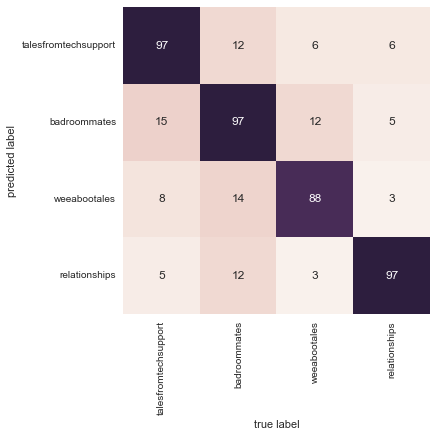

In [42]:
mat = sklearn.metrics.confusion_matrix(redditDfTesting['subreddit'], redditDfTesting['predictionsDT'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=targets, yticklabels=targets)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

But can we do better?

Lets look at random forests

In [43]:
randomForest = sklearn.ensemble.RandomForestClassifier()

Train it:

In [44]:
randomForest.fit(np.stack(redditDfTraining['tfVect'], axis=1)[0], redditDfTraining['subreddit'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Get predictions:

In [45]:
redditDfTesting['predictionsRF'] = randomForest.predict(np.stack(redditDfTesting['tfVect'], axis=1)[0])

And score them:

In [46]:
print(sklearn.metrics.precision_score(redditDfTesting['subreddit'], redditDfTesting['predictionsRF'], average = 'weighted'), 'precision')
print(sklearn.metrics.recall_score(redditDfTesting['subreddit'], redditDfTesting['predictionsRF'], average = 'weighted'), 'recall')
print(sklearn.metrics.f1_score(redditDfTesting['subreddit'], redditDfTesting['predictionsRF'], average = 'weighted'), 'F-1 measure')

0.891172302929 precision
0.889583333333 recall
0.889646304011 F-1 measure


The confusion matrix is:

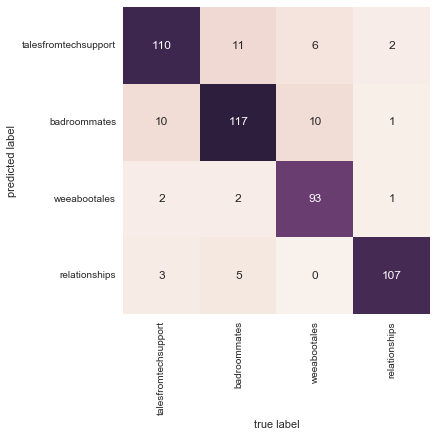

In [47]:
mat = sklearn.metrics.confusion_matrix(redditDfTesting['subreddit'], redditDfTesting['predictionsRF'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=targets, yticklabels=targets)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

We can see that the random forest is a good bit better

Lets look at boosting:

In [48]:
boosting = randomForest = sklearn.ensemble.GradientBoostingClassifier()
boosting.fit(np.stack(redditDfTraining['tfVect'], axis=1)[0], redditDfTraining['subreddit'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

get the predictions

In [49]:
redditDfTesting['predictionsBoost'] = boosting.predict(np.stack(redditDfTesting['tfVect'], axis=1)[0])

And the scores:

In [50]:
print(sklearn.metrics.precision_score(redditDfTesting['subreddit'], redditDfTesting['predictionsBoost'], average = 'weighted'), 'precision')
print(sklearn.metrics.recall_score(redditDfTesting['subreddit'], redditDfTesting['predictionsBoost'], average = 'weighted'), 'recall')
print(sklearn.metrics.f1_score(redditDfTesting['subreddit'], redditDfTesting['predictionsBoost'], average = 'weighted'), 'F-1 measure')

0.923171152451 precision
0.922916666667 recall
0.922505519002 F-1 measure


The confusion matrix is:

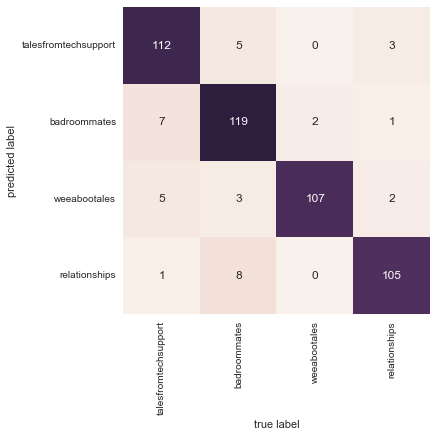

In [51]:
mat = sklearn.metrics.confusion_matrix(redditDfTesting['subreddit'], redditDfTesting['predictionsBoost'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=targets, yticklabels=targets)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

This takes a bit longer to train, but the results are better, what about a combining differnet classifiers with stacking?

To do this we first selected the classifiers then look at their votes for the class, notice we are using three different styles, `LinearRegression` is a simple OLS and boosting our current best is commented out.

In [56]:
classifiers = [
    ('decisionTree', sklearn.tree.DecisionTreeClassifier()),
    ('randomForest', sklearn.ensemble.RandomForestClassifier()),
    ('lin', sklearn.linear_model.LinearRegression()),
    #('boosting', sklearn.ensemble.GradientBoostingClassifier()),
]

stacking = sklearn.ensemble.VotingClassifier(classifiers)

Now we can treat this classifiers the same as all the others

In [57]:
stacking.fit(np.stack(redditDfTraining['tfVect'], axis=1)[0], redditDfTraining['subreddit'])
redditDfTesting['predictionsStacking'] = boosting.predict(np.stack(redditDfTesting['tfVect'], axis=1)[0])

Get the scores:

In [58]:
print(sklearn.metrics.precision_score(redditDfTesting['subreddit'], redditDfTesting['predictionsStacking'], average = 'weighted'), 'precision')
print(sklearn.metrics.recall_score(redditDfTesting['subreddit'], redditDfTesting['predictionsStacking'], average = 'weighted'), 'recall')
print(sklearn.metrics.f1_score(redditDfTesting['subreddit'], redditDfTesting['predictionsStacking'], average = 'weighted'), 'F-1 measure')

0.923171152451 precision
0.922916666667 recall
0.922505519002 F-1 measure


And the confusion matrix:

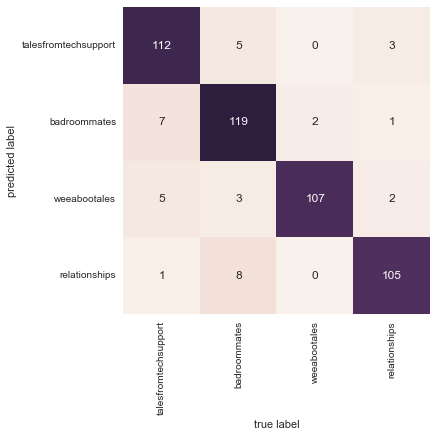

In [59]:
mat = sklearn.metrics.confusion_matrix(redditDfTesting['subreddit'], redditDfTesting['predictionsStacking'])
seaborn.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=targets, yticklabels=targets)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

This is almost as good as boosting, and took much less time.